# Titanic - Machine Learning from Disaster 🛳️

!["Our framework"](Framework.png)


## 1. Problem Definition

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


## 2. Data

Our data is from kaggle website.The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

For the **training set**, they provide the outcome (also known as the “ground truth”) for each passenger. Our model will be based on “features” like passengers’ gender and class. You can also use `feature engineering` to create new features.

For the **test set**, we do not provide the ground truth for each passenger. It is our job to predict these outcomes. For each passenger in the test set, use the model we trained to predict whether or not they survived the sinking of the Titanic.


### Data Dictionary

survival   ►   0 = No, 1 = Yes <br>

pclass   ►   Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd <br>

sex  ►   Sex <br>

Age  ►   Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 <br>

sibsp   ►   The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored) <br>

parch   ► 
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them. <br>

ticket   ►   Ticket number <br>

fare   ►   Passenger fare <br>

cabin   ►   Cabin number <br>

embarked   ►   Port of Embarkation  C = Cherbourg, Q = Queenstown, S = Southampton <br>
 
 
## 3. Evaluation

### Metric

Your score is the percentage of passengers you correctly predict. This is known as accuracy.
We should achieve 1.0 accuracy for being among the best submissions.

## Importing Packages


In [1]:
import pandas as pd
import numpy as np

# Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
%matplotlib inline
import seaborn as sns

# Packages for evaluating our model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_score

# Converting categorical features into numerical
from sklearn.preprocessing import LabelEncoder

# Splitting our data for fitting
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Oversampling
from sklearn.utils import resample

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Read Data From Csv File

In [2]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Total number of samples
len(df)

891

In [4]:
# Getting a better understanding of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Making new columns

Most of the time we have to combine two or more columns to have a new column.<br>
We should be really carefull about the way we combine our columns since it could act like a double-edged sword.<br>

First, we can see that in name column, most of the people have a title for themselves.(like Mr., Miss., Doctor,...) We had more Titles but because they are not more than 10 in numbers, we could ignore them.<br>

Let's use them to create a `Title` column.

### Title Column

In [6]:
# Function for creating Title column
def Title_maker(dataframe):
    """
    In this function, we are going to extract titles from name column and add them to title column.
    """
    dataframe["Title"] = "None"
    dataframe.loc[dataframe["Name"].str.contains("Mrs."), "Title"] = "Mrs"
    dataframe.loc[dataframe["Name"].str.contains("Mr."), "Title"] = "Mr"
    dataframe.loc[dataframe["Name"].str.contains("Miss."), "Title"] = "Miss"
    dataframe.loc[dataframe["Name"].str.contains("Master."), "Title"] = "Master"
    dataframe.loc[dataframe["Name"].str.contains("Dr."), "Title"] = "Dr"
    
    return dataframe.head()

In [7]:
Title_maker(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mr
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mr
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [8]:
# Ignored titles
df.loc[df["Title"] == "None"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,None
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,None
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,None
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,None
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,None
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,None
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,None
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,None
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.3500,NaN,Q,None
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,None


In [9]:
df["Title"].value_counts()

Mr        642
Miss      181
Master     40
None       17
Dr         11
Name: Title, dtype: int64

### Ticket Column
We are going to use first two letters of Ticket column to create a new column called Ticket_2_letters.<br>
The reason for doing this is that working with Ticket column is not an easy job and also having more columns most of the time is a good thing.

In [10]:
def Ticket_2_letters_maker(dataframe):
    """
    Taking the first two letters of Ticket and adding it to new column.
    """
    dataframe["Ticket_2_letters"] = "None"
    dataframe["Ticket_2_letters"] = dataframe["Ticket"].apply(lambda x: x[:2])
    return dataframe.head()

In [11]:
Ticket_2_letters_maker(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2_letters
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mr,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mr,11
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37


### Create Family Size & Family Type Column

We can have `Family size` column using `SibSp` and `Parch` columns to have better understanding of number of family members of a passenger.<br>

Also from Family size column, we can understand the Family Type of a passenger.(Solo, Small, Big, very Big)

In [12]:
def family_size_type_maker(dataframe):
    """
    Using SibSp and Parch columns we are going to create two additional columns, Family Size and Family Type.
    """
    dataframe["Family_size"] = dataframe["SibSp"] + dataframe["Parch"] + 1
    dataframe["Family_type"] = pd.cut(dataframe["Family_size"], [0, 1, 4, 7, 11], labels=["Solo", "Small", "Big", "Very Big"])
    
    return dataframe.head()

In [13]:
family_size_type_maker(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2_letters,Family_size,Family_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mr,PC,2,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST,1,Solo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mr,11,2,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,1,Solo


### Checking Different Columns

In [14]:
# how many of each class there
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

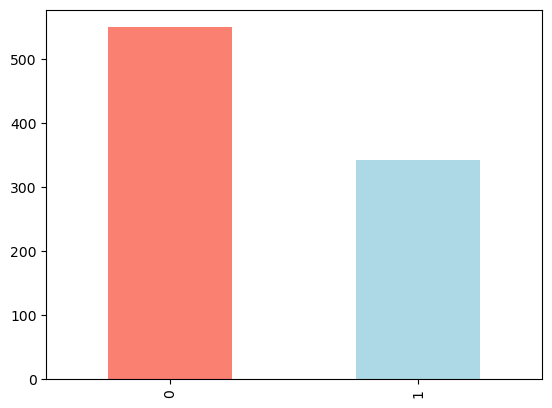

In [15]:
df["Survived"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [16]:
# rearranging columns
df = df.loc[:,['PassengerId', 'Pclass', 'Name', "Title", 'Sex', 'Age', 'SibSp',
               'Parch', 'Family_size', 'Family_type', 'Ticket', 'Ticket_2_letters', 
               'Fare', 'Cabin', 'Embarked',  'Survived']]
df.head()

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Family_size,Family_type,Ticket,Ticket_2_letters,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",Mr,male,22.0,1,0,2,Small,A/5 21171,A/,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mr,female,38.0,1,0,2,Small,PC 17599,PC,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",Miss,female,26.0,0,0,1,Solo,STON/O2. 3101282,ST,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mr,female,35.0,1,0,2,Small,113803,11,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",Mr,male,35.0,0,0,1,Solo,373450,37,8.0500,NaN,S,0


With crosstab in pandas we can compare two columns with each other.<br>

So let's do it!

In [17]:
pd.crosstab(df["Sex"], df["Survived"])

Survived,0,1
Sex,,
female,81,233
male,468,109


As you can see **most of the survivals were women**. On the other hand, men had less chance to survive from titanic.

In [18]:
pd.crosstab(df["Pclass"], df["Survived"])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Also most of the survivals had Class 1 ticket.

## Missing and Categorical Values

Most of the time our dataframe has missing values, so we should find a way to deal with them. We can drop the columns with missing values or fill them with proper values.<br>

Also Categorical values are something that a machine learning model can't work with them, so we should convert our categorical values into numeric values. <br>

In **Overview function** we want to have a function to give us better understanding about Missing and Categorical values.

In [19]:
# Let's create a function to get an overview of our data
def overview(df):
    """
    A function to get an overview of our data and knowing the number of missing values and categorical columns.
    """
    print("First let's see the number of missing values in our data...")
    print("")
    print(df.isna().sum())
    print("")
    print("")
    print("Columns with categorical values...")
    print("")
    print(df.dtypes == "object")

In [20]:
# Let's make the above function more visualize
def visualize(df):
    """
    A function to make overview function more visualize.
    """
    plt.rc("font", size=7)
    fig, (ax1, ax2) = plt.subplots(figsize=(11,6),
                                   nrows=2,
                                   ncols=1,
                                   constrained_layout=True) # For adjusting the space between two plots
    ax1.bar(df.columns, df.isna().sum(),
                color="green")
    ax1.set(title = "Number of missing values")
    
    ax2.bar(df.columns, df.dtypes == "object")
    ax2.set(title = "Categorical or Numerical")
    blueline = mpatches.Patch(color="#1f77b4", label="Categorical") # default blue color with hex value
    ax2.legend(handles=[blueline])
    
    # Make our crosstab more visualize
    pd.crosstab(df["Survived"], df["Sex"]).plot(kind="bar", color=["salmon", "lightblue"])
    plt.title("Survival Frequency for Male and Female")
    plt.xlabel("0 = Dead, 1 = Survival")
    
    pd.crosstab(df["Survived"], df["Pclass"]).plot(kind="bar", color=["gold", "grey", "black"])
    plt.title("Survival Frequency for different Passenger's classes")
    plt.xlabel("0 = Dead, 1 = Survival")
    plt.legend(["First class", "Second class", "Third class"]);


In [21]:
overview(df)

First let's see the number of missing values in our data...

PassengerId           0
Pclass                0
Name                  0
Title                 0
Sex                   0
Age                 177
SibSp                 0
Parch                 0
Family_size           0
Family_type           0
Ticket                0
Ticket_2_letters      0
Fare                  0
Cabin               687
Embarked              2
Survived              0
dtype: int64


Columns with categorical values...

PassengerId         False
Pclass              False
Name                 True
Title                True
Sex                  True
Age                 False
SibSp               False
Parch               False
Family_size         False
Family_type         False
Ticket               True
Ticket_2_letters     True
Fare                False
Cabin                True
Embarked             True
Survived            False
dtype: bool


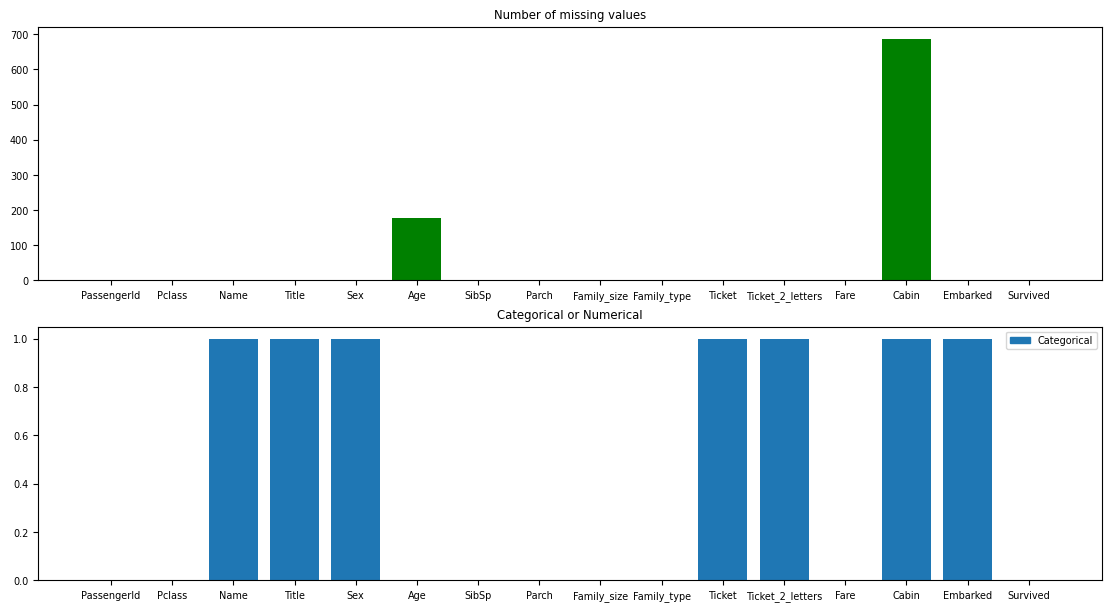

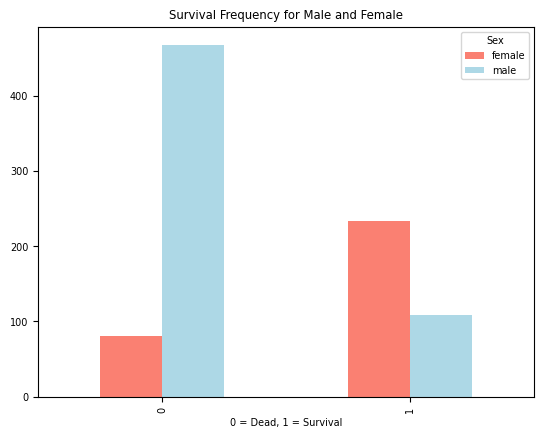

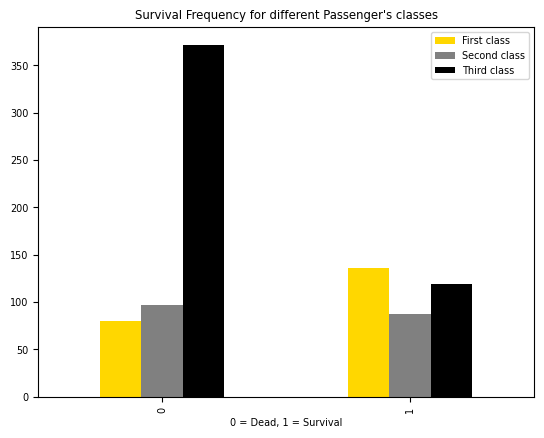

In [22]:
visualize(df)

## Missing Values

As you can see there are 3 columns with missing value:
* Age ✅
* Cabin ✅
* Embarked ✅

Let's check them and decide what to do with them.<br>

It's good to know how to fill missing values for numerical columns.<br>

`Mean` imputation works better if the distribution is **normally-distributed or has a Gaussian distribution**, while `median` imputation is preferable for **skewed distribution**(be it right or left).<br>
For more information: https://medium.com/analytics-vidhya/appropriate-ways-to-treat-missing-values-f82f00edd9be

### Age Column

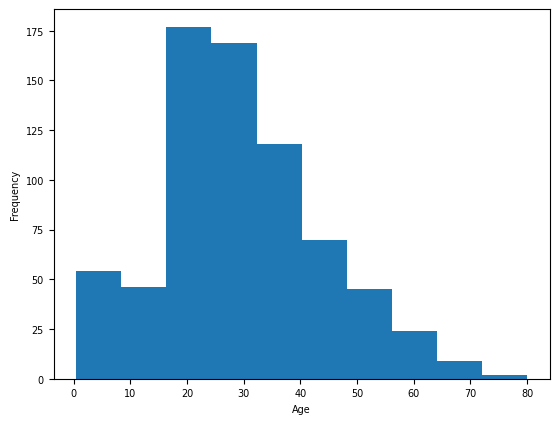

In [23]:
df["Age"].plot(kind="hist")
plt.xlabel("Age");

In [24]:
df["Age"].mean(), df["Age"].median(), df["Age"].std(), df["Age"].mode() # most repeated element

(29.69911764705882,
 28.0,
 14.526497332334044,
 0    24.0
 Name: Age, dtype: float64)

As you can see we should fill our missing values in Age column with **mean( )**.

### Cabin Column

In [25]:
df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

As you can see above in length section, there are too many missing values in Cabin column.<br>

So I decided to **drop** Cabin Column!<br>

### Embarked Column

In [26]:
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [27]:
df["Embarked"].mode()[0]

'S'

In [28]:
def fill_missing_values(df):
    """
    In this function we can fill missing values...
    """
    # Fill Age missing values with mean()
    df["Age"] = df["Age"].fillna(df["Age"].median())
    
    # too many missing values for Cabin column
    df.drop("Cabin", axis=1, inplace=True)
    
    # Fill Embarked missing values with most repeated element
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    
    return df.head()

In [29]:
fill_missing_values(df)

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Family_size,Family_type,Ticket,Ticket_2_letters,Fare,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",Mr,male,22.0,1,0,2,Small,A/5 21171,A/,7.2500,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mr,female,38.0,1,0,2,Small,PC 17599,PC,71.2833,C,1
2,3,3,"Heikkinen, Miss. Laina",Miss,female,26.0,0,0,1,Solo,STON/O2. 3101282,ST,7.9250,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mr,female,35.0,1,0,2,Small,113803,11,53.1000,S,1
4,5,3,"Allen, Mr. William Henry",Mr,male,35.0,0,0,1,Solo,373450,37,8.0500,S,0


In [30]:
overview(df)

First let's see the number of missing values in our data...

PassengerId         0
Pclass              0
Name                0
Title               0
Sex                 0
Age                 0
SibSp               0
Parch               0
Family_size         0
Family_type         0
Ticket              0
Ticket_2_letters    0
Fare                0
Embarked            0
Survived            0
dtype: int64


Columns with categorical values...

PassengerId         False
Pclass              False
Name                 True
Title                True
Sex                  True
Age                 False
SibSp               False
Parch               False
Family_size         False
Family_type         False
Ticket               True
Ticket_2_letters     True
Fare                False
Embarked             True
Survived            False
dtype: bool


Now we filled all of our missing values with proper values.<br>

It's time to convert our categorical columns into numerical.

## Convert Categorical columns to Numerical

In [31]:
# Columns with string
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Name
Title
Sex
Ticket
Ticket_2_letters
Embarked


As you can see there are 5 columns to convert into numerical format.
* Name ✅
* Title ✅
* Sex ✅
* Ticket ✅
* Ticket_2_letters ✅
* Embarked ✅


Since using **get_dummies()** is going to add to number of our columns.
I use **LabelEncoder** method to convert String column into numeric format.<br>

Also for columns with numerous values, the best approach is to convert them into **categorical format** and then use **cat.codes** to convert them into numerical format.

In [32]:
def convert_to_numeric(df):
    """
    we are going to make decisions about categorical columns in this function...
    """
    # Name and Ticket columns are no longer usefull since we extracted the useful information from them.
    # We can drop both of them!!
    df.drop(["Name", "Ticket"], axis=1, inplace=True)
    
    # Encoding Sex, Embarked, Title, Family_type
    le = LabelEncoder()
    Sex_label = le.fit_transform(df["Sex"])
    Embarked_label = le.fit_transform(df["Embarked"])
    Title_label = le.fit_transform(df["Title"])
    Family_label = le.fit_transform(df["Family_type"])
    
    # Removing old values from our columns
    df.drop("Sex", axis=1, inplace=True)
    df.drop("Embarked", axis=1, inplace=True)
    df.drop("Title", axis=1, inplace=True)
    df.drop("Family_type", axis=1, inplace=True)

    # Replace Sex and Embarked column with numerical values
    df["Sex"] = Sex_label
    df["Embarked"] = Embarked_label
    df["Title"] = Title_label
    df["Family_type"] = Family_label
    
    # Since Ticket_2_letters has too many values we are going to use category type to convert it into numeric form
    df["Ticket_2_letters"] = df["Ticket_2_letters"].astype("category").cat.as_ordered()
    df["Ticket_2_letters"] = df["Ticket_2_letters"].cat.codes
    
    return df.head()

In [33]:
convert_to_numeric(df)

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type
0,1,3,22.0,1,0,2,37,7.2500,0,1,2,3,1
1,2,1,38.0,1,0,2,46,71.2833,1,0,0,3,1
2,3,3,26.0,0,0,1,51,7.9250,1,0,2,2,2
3,4,1,35.0,1,0,2,0,53.1000,1,0,2,3,1
4,5,3,35.0,0,0,1,23,8.0500,0,1,2,3,2


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Age               891 non-null    float64
 3   SibSp             891 non-null    int64  
 4   Parch             891 non-null    int64  
 5   Family_size       891 non-null    int64  
 6   Ticket_2_letters  891 non-null    int8   
 7   Fare              891 non-null    float64
 8   Survived          891 non-null    int64  
 9   Sex               891 non-null    int64  
 10  Embarked          891 non-null    int64  
 11  Title             891 non-null    int64  
 12  Family_type       891 non-null    int64  
dtypes: float64(2), int64(10), int8(1)
memory usage: 84.5 KB


## EDA ( phase 2 )

### Outliers
In statistics, an outlier is an observation point that is distant from other observations.<br>
If they are the result of a mistake, then we can ignore them, but if it is just a variance in the data we would need think a bit further.<br>
We will use `boxplot` to spot outliers. If there is an outlier it will plotted as point in boxplot but other population will be grouped together and display as boxes.<br>
For outliers you can check this out: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

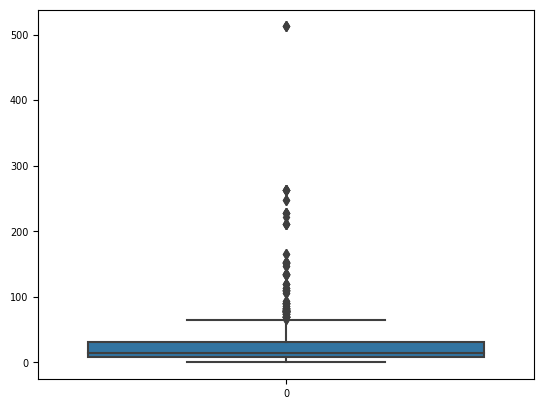

In [35]:
# let's see outliers in our Fare column
sns.boxplot(df["Fare"]);

But it only showed us Uni-variate outlier.<br>
let's try scatter plot...<br>
The `scatter` plot is the collection of points that shows values for two variables.

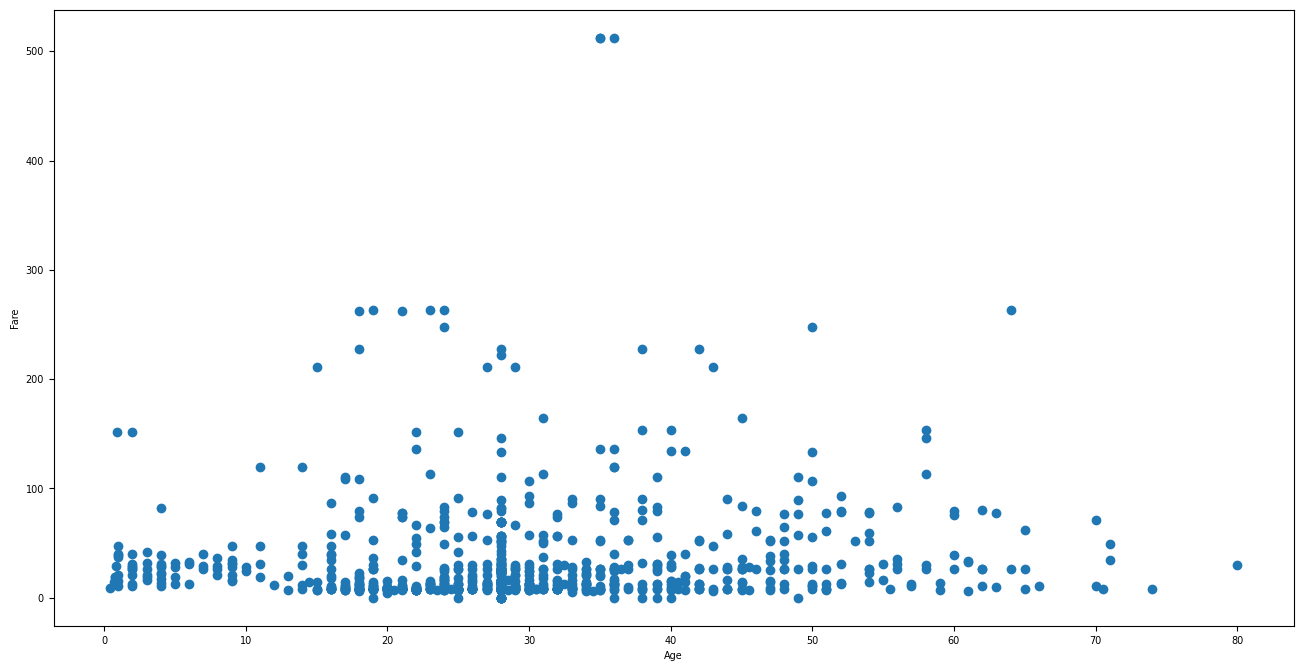

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(df["Age"], df["Fare"])
ax.set_xlabel("Age")
ax.set_ylabel("Fare");

In [37]:
df.loc[df["Fare"] > 300]

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type
258,259,1,35.0,0,0,1,46,512.3292,1,0,0,2,2
679,680,1,36.0,0,1,2,46,512.3292,1,1,0,0,1
737,738,1,35.0,0,0,1,46,512.3292,1,1,0,3,2


In [38]:
df.loc[df["Age"] > 70]

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type
96,97,1,71.0,0,0,1,46,34.6542,0,1,0,3,2
116,117,3,70.5,0,0,1,23,7.7500,0,1,1,3,2
493,494,1,71.0,0,0,1,46,49.5042,0,1,0,3,2
630,631,1,80.0,0,0,1,14,30.0000,1,1,2,3,2
851,852,3,74.0,0,0,1,20,7.7750,0,1,2,3,2


In [39]:
# removing outliers with numerical conditions
df_out = df.loc[(df["Fare"] <= 300) & (df["Age"] <= 70)] 
df_out.head()

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type
0,1,3,22.0,1,0,2,37,7.2500,0,1,2,3,1
1,2,1,38.0,1,0,2,46,71.2833,1,0,0,3,1
2,3,3,26.0,0,0,1,51,7.9250,1,0,2,2,2
3,4,1,35.0,1,0,2,0,53.1000,1,0,2,3,1
4,5,3,35.0,0,0,1,23,8.0500,0,1,2,3,2


In [40]:
df_out[df_out["PassengerId"] == 117]

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type


In [41]:
len(df_out)

883

As you can see the outliers have been deleted...

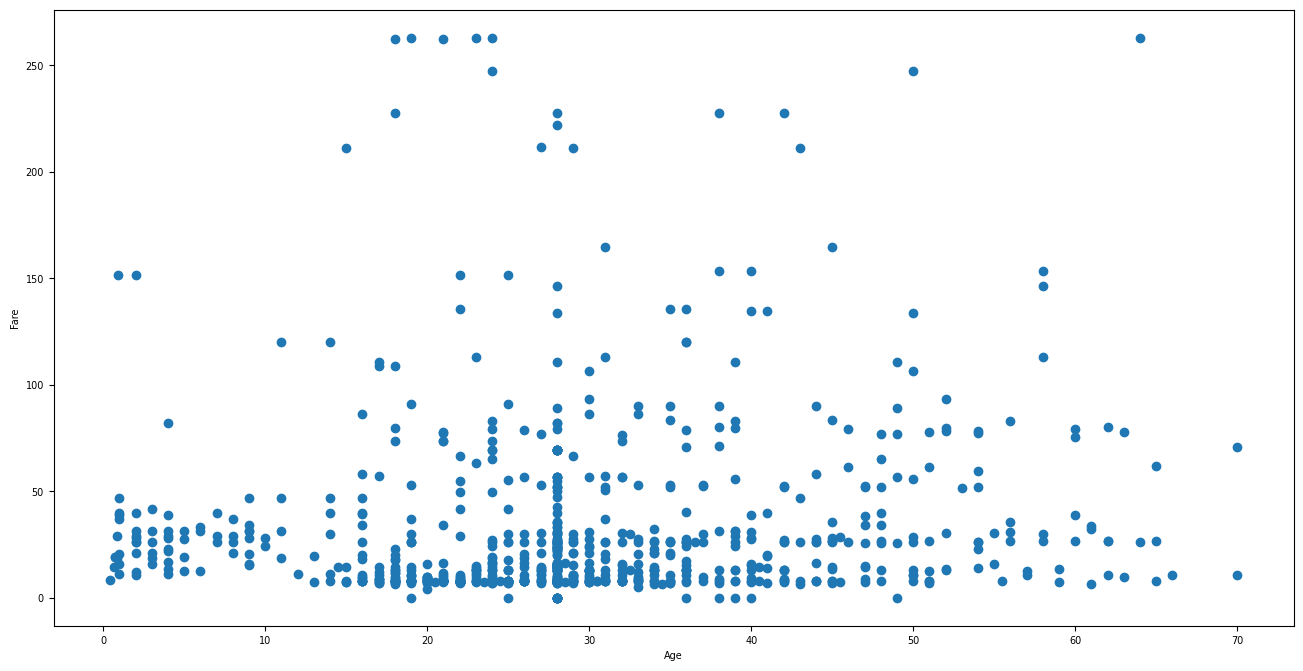

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(df_out["Age"], df_out["Fare"])
ax.set_xlabel("Age")
ax.set_ylabel("Fare");

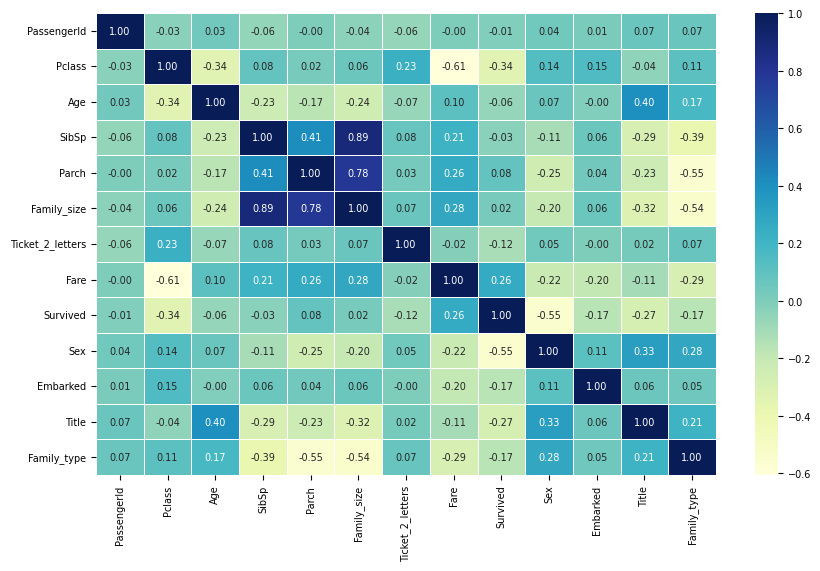

In [43]:
# let's see our correlation matrix before modelling
corr_matrix = df_out.corr()
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidth=0.5, # for putting some space between two squares
                 fmt=".2f",
                 cmap="YlGnBu");

## Saving Preprocessed Data

It's good thing to save our data after preprocessing

In [44]:
df_out.to_csv("Final_train_dataset.csv",
              index=False)

In [45]:
df_out = pd.read_csv("Final_train_dataset.csv",
                     low_memory=False)
df_out.head()

,PassengerId,Pclass,Age,SibSp,Parch,Family_size,Ticket_2_letters,Fare,Survived,Sex,Embarked,Title,Family_type
0,1,3,22.0,1,0,2,37,7.2500,0,1,2,3,1
1,2,1,38.0,1,0,2,46,71.2833,1,0,0,3,1
2,3,3,26.0,0,0,1,51,7.9250,1,0,2,2,2
3,4,1,35.0,1,0,2,0,53.1000,1,0,2,3,1
4,5,3,35.0,0,0,1,23,8.0500,0,1,2,3,2


In [46]:
# rearranging columns
df_out = df_out.loc[:,['PassengerId', 'Pclass', "Title", 'Sex', 'Age', 'SibSp',
                       'Parch', 'Family_size', 'Family_type', 'Ticket_2_letters', 
                       'Fare', 'Embarked', 'Survived']]
df_out.head()

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Family_size,Family_type,Ticket_2_letters,Fare,Embarked,Survived
0,1,3,3,1,22.0,1,0,2,1,37,7.2500,2,0
1,2,1,3,0,38.0,1,0,2,1,46,71.2833,0,1
2,3,3,2,0,26.0,0,0,1,2,51,7.9250,2,1
3,4,1,3,0,35.0,1,0,2,1,0,53.1000,2,1
4,5,3,3,1,35.0,0,0,1,2,23,8.0500,2,0


In [47]:
len(df_out)

883

### Oversampling
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.<br>
**Note:** Always split into test and train sets BEFORE trying oversampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. <br>
For more information: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [48]:
from sklearn.utils import resample

# First let's specify X & y
X_out = df_out.drop("Survived", axis=1)
y_out = df_out["Survived"]


# Now it's time to split the data
X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out,
                                                                    y_out, 
                                                                    random_state=42,
                                                                    shuffle=True,
                                                                    test_size=0.2)
#-----
# concatenate our training data back together
train_data = pd.concat([X_out_train, y_out_train], axis=1)

# separate minority and majority classes
survived = train_data[train_data["Survived"] == 1]
not_survived = train_data[train_data["Survived"] == 0]

# oversample minority
oversampled_df = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(not_survived),
                          random_state=42)

# combine majority and oversampled minority
concat_df = pd.concat([not_survived, oversampled_df])

concat_df["Survived"].value_counts()

0    434
1    434
Name: Survived, dtype: int64

In [49]:
X_out_train = concat_df.drop("Survived", axis=1)
y_out_train = concat_df["Survived"]

Also it would be nice to have devided data **without oversampling** method.

In [50]:
X = df_out.drop("Survived", axis=1)
y = df_out["Survived"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((706, 12), (177, 12), (706,), (177,))

## Modelling

Let's create a function for fitting the data to our model.

In [51]:
# put models in a dictionary
models = {"SVC": SVC(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Logistic Regression": LogisticRegression(max_iter=10000)}
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Setup a random seed
    np.random.seed(42)
    # Make a dictionary to keep model's scores
    scores = {}
    
    for label, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append to our scores dictionary
        scores[label] = model.score(X_test, y_test)
    
    return scores

## Evaluation Function

A function to evaluate and measure important metrics.

In [52]:
# let's create a function for evaluating our models with different methods
def evaluation(model, X_train, X_test, y_train, y_test):
    """
    In this function we are going to evaluate our model with different type of methods
    to have a better understanding from our model's performance.
    """
    # setup a random seed
    np.random.seed(42)
    
    # we want model predictions
    y_preds = model.predict(X_test)
    
    # evaluation metrics
    print("Evaluating on test set...")
    print(f"Let's see the confusion matrix for our model on the test set \n {confusion_matrix(y_test, y_preds)}")
    print(f"Accuracy score: {accuracy_score(y_test, y_preds)}")
    print(f"Precision score: {precision_score(y_test, y_preds)}")
    print(f"Recall score: {recall_score(y_test, y_preds)}")
    print(f"F1-score: {f1_score(y_test, y_preds)}")
    print(f"Mean absolute error: {mean_absolute_error(y_test, y_preds)}")
    print(f"R2 score: {r2_score(y_test, y_preds)}")
    print(f"Root mean squared log error: {np.sqrt(mean_squared_log_error(y_test, y_preds))}")

### Fit & Evaluation Phase

In [53]:
# Oversmapled data
fit_and_score(models,
              X_out_train,
              X_out_test,
              y_out_train,
              y_out_test)



{'SVC': 0.7288135593220338,
 'KNN': 0.6440677966101694,
 'Random Forest': 0.8700564971751412,
 'Logistic Regression': 0.7853107344632768}

In [54]:
# Not oversampled data
fit_and_score(models,
              X_train,
              X_test,
              y_train, 
              y_test)

{'SVC': 0.6779661016949152,
 'KNN': 0.655367231638418,
 'Random Forest': 0.8700564971751412,
 'Logistic Regression': 0.8305084745762712}

In [55]:
# Oversampled data
np.random.seed(42)

# Instantiate our model
model_rf_ov = RandomForestClassifier()
model_rf_ov.fit(X_out_train, y_out_train)

# Evaluation function on our model
evaluation(model_rf_ov,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)
np.mean(cross_val_score(model_rf_ov, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [10 56]]
Accuracy score: 0.8700564971751412
Precision score: 0.8115942028985508
Recall score: 0.8484848484848485
F1-score: 0.8296296296296296
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.815414740626605

In [56]:
# Not oversampled data
np.random.seed(42)

# Instantiate our model
model_rf_nov = RandomForestClassifier()
model_rf_nov.fit(X_train, y_train)

evaluation(model_rf_nov,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(model_rf_nov, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [10 56]]
Accuracy score: 0.8700564971751412
Precision score: 0.8115942028985508
Recall score: 0.8484848484848485
F1-score: 0.8296296296296296
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.815414740626605

In [57]:
# Oversmapled data
np.random.seed(42)
catboost_model_ov = CatBoostClassifier(verbose=False)
catboost_model_ov.fit(X_out_train, y_out_train)

evaluation(catboost_model_ov,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)

np.mean(cross_val_score(catboost_model_ov, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[95 16]
 [ 9 57]]
Accuracy score: 0.8587570621468926
Precision score: 0.7808219178082192
Recall score: 0.8636363636363636
F1-score: 0.8201438848920863
Mean absolute error: 0.14124293785310735
R2 score: 0.39598689598689596
Root mean squared log error: 0.26050066254462123


0.8018425783256292

In [58]:
# Oversampled data

xgboost_model_ov = XGBClassifier()
xgboost_model_ov.fit(X_out_train, y_out_train)

evaluation(xgboost_model_ov,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)

np.mean(cross_val_score(xgboost_model_ov, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[102   9]
 [ 13  53]]
Accuracy score: 0.8757062146892656
Precision score: 0.8548387096774194
Recall score: 0.803030303030303
F1-score: 0.828125
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.2443712826087473


0.8086800205444273

In [59]:
# Not oversmapled data
np.random.seed(42)

catboost_model_ov = CatBoostClassifier(verbose=False)
catboost_model_ov.fit(X_train, y_train)

evaluation(catboost_model_ov,
           X_train,
           X_test,
           y_train,
           y_test)

np.mean(cross_val_score(catboost_model_ov, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[101  10]
 [ 10  56]]
Accuracy score: 0.8870056497175142
Precision score: 0.8484848484848485
Recall score: 0.8484848484848485
F1-score: 0.8484848484848486
Mean absolute error: 0.11299435028248588
R2 score: 0.5167895167895168
Root mean squared log error: 0.23299887585340257


0.8018425783256292

we can use hyperparameter tuning for xgboost<br>
for more information: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [60]:
# Oversampled data
np.random.seed(42)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
                                                  param_grid = param_test1,
                                                  n_jobs=4, 
                                                  cv=5)
gsearch1.fit(X_out_train, y_out_train)


evaluation(gsearch1,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)
np.mean(cross_val_score(gsearch1, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[101  10]
 [ 12  54]]
Accuracy score: 0.8757062146892656
Precision score: 0.84375
Recall score: 0.8181818181818182
F1-score: 0.8307692307692308
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.2443712826087473


0.8120570107858244

In [61]:
# Not oversampled data
np.random.seed(42)

gsearch1.fit(X_train, y_train)

evaluation(gsearch1,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(gsearch1, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[99 12]
 [11 55]]
Accuracy score: 0.8700564971751412
Precision score: 0.8208955223880597
Recall score: 0.8333333333333334
F1-score: 0.8270676691729324
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.8120570107858244

In [63]:
np.random.seed(42)

# Create a hyperparameter grid for RandomForestClassifier
rf_distribution = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(10, 18, 2),
           "min_samples_leaf": np.arange(1, 6, 1)}

# Setup random hyperparameter search for RandomForestClassifier
tuned_rf = RandomizedSearchCV(model_rf_nov,
                              param_distributions=rf_distribution,
                              cv=5,
                              n_iter=20,
                              verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
tuned_rf.fit(X_out_train, y_out_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([10, 12, 14, 16]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [64]:
tuned_rf.best_params_
tf = pd.DataFrame(tuned_rf.cv_results_)
tf.sort_values("rank_test_score")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.251409,0.002409,0.012705,0.000245,460,10,1,None,"{'n_estimators': 460, 'min_samples_split': 10,...",0.919540,0.839080,0.867816,0.878613,0.820809,0.865172,0.034036,1
4,0.366036,0.016188,0.018314,0.000047,660,10,2,None,"{'n_estimators': 660, 'min_samples_split': 10,...",0.908046,0.839080,0.856322,0.884393,0.815029,0.860574,0.032788,2
2,0.359991,0.005099,0.018127,0.000194,660,12,1,None,"{'n_estimators': 660, 'min_samples_split': 12,...",0.913793,0.833333,0.862069,0.878613,0.815029,0.860567,0.034573,3
12,0.433452,0.003862,0.021783,0.000231,810,14,1,None,"{'n_estimators': 810, 'min_samples_split': 14,...",0.908046,0.833333,0.867816,0.872832,0.815029,0.859411,0.032453,4
7,0.388935,0.004738,0.020198,0.000734,710,10,2,None,"{'n_estimators': 710, 'min_samples_split': 10,...",0.913793,0.833333,0.856322,0.872832,0.815029,0.858262,0.034030,5
5,0.113967,0.000571,0.006193,0.000386,210,10,2,None,"{'n_estimators': 210, 'min_samples_split': 10,...",0.896552,0.833333,0.856322,0.884393,0.815029,0.857126,0.030453,6
15,0.059636,0.000351,0.003366,0.000051,110,14,1,None,"{'n_estimators': 110, 'min_samples_split': 14,...",0.902299,0.816092,0.867816,0.872832,0.809249,0.853658,0.035546,7
14,0.324631,0.001229,0.016676,0.000393,610,14,2,None,"{'n_estimators': 610, 'min_samples_split': 14,...",0.908046,0.821839,0.856322,0.867052,0.809249,0.852501,0.034993,8
9,0.165123,0.001225,0.008551,0.000060,310,14,2,None,"{'n_estimators': 310, 'min_samples_split': 14,...",0.908046,0.833333,0.827586,0.872832,0.815029,0.851365,0.034306,9
13,0.324155,0.004340,0.016685,0.000552,610,16,1,None,"{'n_estimators': 610, 'min_samples_split': 16,...",0.902299,0.821839,0.839080,0.872832,0.815029,0.850216,0.032837,10


In [65]:
# Not oversampled data
np.random.seed(42)


# Setup random hyperparameter search for RandomForestClassifier
tuned_rf_nov = RandomizedSearchCV(model_rf_nov,
                                  param_distributions=rf_distribution,
                                  cv=5,
                                  n_iter=20,
                                  verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
tuned_rf_nov.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([10, 12, 14, 16]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [66]:
tf_nov = pd.DataFrame(tuned_rf_nov.cv_results_)
tf_nov.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.337932,0.001709,0.016589,0.000224,660,12,1,None,"{'n_estimators': 660, 'min_samples_split': 12,...",0.852113,0.815603,0.801418,0.801418,0.822695,0.818649,0.018651,1
14,0.310255,0.006106,0.015646,0.000485,610,14,2,None,"{'n_estimators': 610, 'min_samples_split': 14,...",0.859155,0.801418,0.801418,0.815603,0.815603,0.818639,0.021228,2
13,0.312904,0.004384,0.015607,0.000284,610,16,1,None,"{'n_estimators': 610, 'min_samples_split': 16,...",0.873239,0.794326,0.801418,0.801418,0.815603,0.817201,0.028859,3
9,0.156339,0.001062,0.007955,0.000110,310,14,2,None,"{'n_estimators': 310, 'min_samples_split': 14,...",0.866197,0.794326,0.801418,0.801418,0.815603,0.815793,0.026133,4
10,0.241057,0.003873,0.011967,0.000352,460,10,1,None,"{'n_estimators': 460, 'min_samples_split': 10,...",0.845070,0.815603,0.801418,0.794326,0.815603,0.814404,0.017407,5
12,0.424532,0.016252,0.020696,0.000378,810,14,1,None,"{'n_estimators': 810, 'min_samples_split': 14,...",0.852113,0.801418,0.801418,0.808511,0.808511,0.814394,0.019124,6
17,0.395960,0.002894,0.019903,0.000290,810,14,5,None,"{'n_estimators': 810, 'min_samples_split': 14,...",0.852113,0.787234,0.794326,0.822695,0.815603,0.814394,0.022950,7
5,0.107459,0.000572,0.005573,0.000027,210,10,2,None,"{'n_estimators': 210, 'min_samples_split': 10,...",0.866197,0.794326,0.794326,0.801418,0.815603,0.814374,0.027051,8
19,0.133171,0.001440,0.007086,0.000165,260,16,5,None,"{'n_estimators': 260, 'min_samples_split': 16,...",0.845070,0.787234,0.801418,0.815603,0.815603,0.812986,0.019184,9
7,0.362393,0.004086,0.018101,0.000590,710,10,2,None,"{'n_estimators': 710, 'min_samples_split': 10,...",0.845070,0.801418,0.801418,0.801418,0.808511,0.811567,0.016975,10


In [67]:
evaluation(tuned_rf,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)


Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[97 14]
 [ 9 57]]
Accuracy score: 0.8700564971751412
Precision score: 0.8028169014084507
Recall score: 0.8636363636363636
F1-score: 0.832116788321168
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


In [68]:
evaluation(tuned_rf_nov,
           X_train,
           X_test,
           y_train,
           y_test)


Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [ 9 57]]
Accuracy score: 0.8757062146892656
Precision score: 0.8142857142857143
Recall score: 0.8636363636363636
F1-score: 0.8382352941176471
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.24437128260874733


In [69]:
np.random.seed(42)
new_model = RandomForestClassifier(n_estimators=460,
                                   min_samples_split= 10,
                                   min_samples_leaf= 1,
                                   max_depth= None)
new_model.fit(X_out_train, y_out_train)
evaluation(new_model,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)
np.mean(cross_val_score(new_model, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[97 14]
 [ 9 57]]
Accuracy score: 0.8700564971751412
Precision score: 0.8028169014084507
Recall score: 0.8636363636363636
F1-score: 0.832116788321168
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.8233371854134566

In [70]:
# Not oversampled data
np.random.seed(42)
new_model_nov = RandomForestClassifier(n_estimators=460,
                                   min_samples_split= 10,
                                   min_samples_leaf= 1,
                                   max_depth= None)
new_model_nov.fit(X_train, y_train)
evaluation(new_model_nov,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(new_model_nov, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [ 9 57]]
Accuracy score: 0.8757062146892656
Precision score: 0.8142857142857143
Recall score: 0.8636363636363636
F1-score: 0.8382352941176471
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.24437128260874733


0.8233371854134566

In [72]:
# Hyperparameter tuning for RandomForest model using GridSearchCV
np.random.seed(42)

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(200, 900, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(10, 17, 2),
           "min_samples_leaf": np.arange(1, 6, 1)}

grid_tuned_rf = GridSearchCV(model_rf_nov,
                             rf_grid,
                             n_jobs=-1,
                             cv=5,
                             verbose=2)

grid_tuned_rf.fit(X_out_train, y_out_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None],
                         'min_samples_leaf': array([1, 2, 3, 4, 5]),
                         'min_samples_split': array([10, 12, 14, 16]),
                         'n_estimators': array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,
       850])},
             verbose=2)

In [73]:
grid_search_rf = pd.DataFrame(grid_tuned_rf.cv_results_)
grid_search_rf.sort_values("rank_test_score").head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.191451,0.004309,0.011393,0.002793,None,1,10,250,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.913793,0.844828,0.867816,0.884393,0.826590,0.867484,0.030385,1
8,0.460149,0.015310,0.023914,0.000498,None,1,10,600,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.925287,0.833333,0.867816,0.884393,0.820809,0.866328,0.037324,2
0,0.156519,0.008873,0.009616,0.002196,None,1,10,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.919540,0.844828,0.862069,0.884393,0.820809,0.866328,0.033794,3
10,0.546613,0.024599,0.031449,0.002488,None,1,10,700,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.919540,0.844828,0.867816,0.884393,0.815029,0.866321,0.035367,4
19,0.387680,0.027890,0.018274,0.002754,None,1,12,450,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.925287,0.833333,0.862069,0.878613,0.826590,0.865178,0.035515,5
14,0.166115,0.016226,0.008819,0.002727,None,1,12,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.925287,0.839080,0.862069,0.884393,0.815029,0.865172,0.037916,6
2,0.244364,0.037967,0.011932,0.002747,None,1,10,300,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.919540,0.839080,0.867816,0.878613,0.820809,0.865172,0.034036,6
3,0.268218,0.016399,0.010888,0.000582,None,1,10,350,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.913793,0.839080,0.867816,0.884393,0.815029,0.864022,0.034435,8
69,0.683216,0.008898,0.032275,0.002271,None,2,10,850,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.925287,0.839080,0.856322,0.884393,0.815029,0.864022,0.038079,8
5,0.350603,0.004178,0.017149,0.002743,None,1,10,450,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.919540,0.833333,0.867816,0.878613,0.820809,0.864022,0.034982,8


In [74]:
final_model_rf = RandomForestClassifier(max_depth= None,
                                        min_samples_leaf= 1,
                                        min_samples_split= 10,
                                        n_estimators= 400)
final_model_rf.fit(X_out_train, y_out_train)
np.random.seed(42)
evaluation(final_model_rf,
           X_out_train,
           X_out_test,
           y_out_train,
           y_out_test)
np.mean(cross_val_score(final_model_rf, X_out, y_out, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[97 14]
 [ 9 57]]
Accuracy score: 0.8700564971751412
Precision score: 0.8028169014084507
Recall score: 0.8636363636363636
F1-score: 0.832116788321168
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.8256034925526452

In [75]:
final_model_rf_nov = RandomForestClassifier(max_depth= None,
                                            min_samples_leaf= 1,
                                            min_samples_split= 10,
                                            n_estimators= 400)
final_model_rf_nov.fit(X_train, y_train)
np.random.seed(42)
evaluation(final_model_rf_nov,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(final_model_rf_nov, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [ 9 57]]
Accuracy score: 0.8757062146892656
Precision score: 0.8142857142857143
Recall score: 0.8636363636363636
F1-score: 0.8382352941176471
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.24437128260874733


0.8256034925526452

As you can see in the above section most of the models work better with normal data (Not oversampled).<br>
So let's do experimetation phase on normal data.

## Experimentation phase on Normal Data ( Not oversampled )

In [76]:
np.random.seed(42)

fit_and_score(models,
              X_train,
              X_test,
              y_train, 
              y_test)

{'SVC': 0.6779661016949152,
 'KNN': 0.655367231638418,
 'Random Forest': 0.8700564971751412,
 'Logistic Regression': 0.8305084745762712}

Let's try to tune 4 models:
* Random Forest
* Logistic Regression
* CatBoost Classifier
* XGBoost Classifier

### Random Forest Classifier

In [77]:
# Let's start with basic RandomForestClassifier model
np.random.seed(42)

# Instantiate model
rf_normal_base = RandomForestClassifier()
rf_normal_base.fit(X_train, y_train)

evaluation(rf_normal_base,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(rf_normal_base, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [10 56]]
Accuracy score: 0.8700564971751412
Precision score: 0.8115942028985508
Recall score: 0.8484848484848485
F1-score: 0.8296296296296296
Mean absolute error: 0.12994350282485875
R2 score: 0.4443079443079443
Root mean squared log error: 0.24986345785506872


0.815414740626605

In [78]:
np.random.seed(42)

# Create a hyperparameter grid for RandomForestClassifier
rf_distribution = {"n_estimators": np.arange(100, 900, 100),
                   "max_depth": [None],
                   "min_samples_split": np.arange(10, 15, 2),
                   "min_samples_leaf": np.arange(1, 3, 1)}


# Setup Grid hyperparameter search for RandomForestClassifier
rf_normal_gridhyp = GridSearchCV(rf_normal_base,
                                 param_grid=rf_distribution,
                                 cv=5,
                                 verbose=True)

# Fit Grid hyperparameter search model for RandomForestClassifier()
rf_normal_gridhyp.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'min_samples_leaf': array([1, 2]),
                         'min_samples_split': array([10, 12, 14]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800])},
             verbose=True)

In [79]:
tf = pd.DataFrame(rf_normal_gridhyp.cv_results_)
tf.sort_values("rank_test_score").head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.357262,0.001619,0.017499,0.000104,None,2,10,700,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.866197,0.808511,0.801418,0.815603,0.822695,0.822885,0.022788,1
11,0.213798,0.003244,0.010837,0.000354,None,1,12,400,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.866197,0.808511,0.801418,0.801418,0.822695,0.820048,0.024347,2
9,0.106025,0.002260,0.005539,0.000322,None,1,12,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.852113,0.815603,0.801418,0.801418,0.822695,0.818649,0.018651,3
14,0.372787,0.010359,0.028856,0.020267,None,1,12,700,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.852113,0.815603,0.801418,0.808511,0.815603,0.818649,0.017539,3
21,0.311442,0.001846,0.015749,0.000539,None,1,14,600,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.859155,0.801418,0.801418,0.808511,0.822695,0.818639,0.021696,5
0,0.053363,0.000788,0.003093,0.000133,None,1,10,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.859155,0.801418,0.794326,0.808511,0.829787,0.818639,0.023478,6
34,0.152599,0.000322,0.007672,0.000059,None,2,12,300,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.873239,0.801418,0.801418,0.808511,0.808511,0.818620,0.027494,7
8,0.053947,0.000894,0.003218,0.000173,None,1,12,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.880282,0.801418,0.801418,0.787234,0.822695,0.818610,0.032850,8
44,0.250747,0.000802,0.012415,0.000071,None,2,14,500,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.852113,0.801418,0.801418,0.808511,0.822695,0.817231,0.019093,9
43,0.202332,0.000496,0.010177,0.000094,None,2,14,400,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.852113,0.808511,0.801418,0.815603,0.808511,0.817231,0.018008,9


In [80]:
rf_grid_model = RandomForestClassifier(max_depth=None,
                                       min_samples_leaf=1,
                                       min_samples_split=12,
                                       n_estimators=660)
rf_grid_model.fit(X_train, y_train)

evaluation(rf_grid_model,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(rf_grid_model, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[98 13]
 [ 9 57]]
Accuracy score: 0.8757062146892656
Precision score: 0.8142857142857143
Recall score: 0.8636363636363636
F1-score: 0.8382352941176471
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.24437128260874733


0.8233436055469954

### Logistic Regression

In [81]:
np.random.seed(42)

lr = LogisticRegression(n_jobs=-1, max_iter=1000)
lr.fit(X_train, y_train)
evaluation(lr,
           X_train, 
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(lr, X, y, cv=5))

/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[92 19]
 [11 55]]
Accuracy score: 0.8305084745762712
Precision score: 0.7432432432432432
Recall score: 0.8333333333333334
F1-score: 0.7857142857142858
Mean absolute error: 0.1694915254237288
R2 score: 0.27518427518427513
Root mean squared log error: 0.2853641782414603


/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7928030303030302

In [82]:
# GridSearch for LogisticRegression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'none'],
    'C' : np.logspace(-1, 1, 5),
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [1000, 2000]
    }
]
logModel = LogisticRegression()
log_gridhyp = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
log_gridhyp.fit(X_train, y_train)

/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packag

Fitting 3 folds for each of 90 candidates, totalling 270 fits


/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed

/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mehrad/Desktop/titanic-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ]),
                          'max_iter': [1000, 2000],
                          'penalty': ['l1', 'l2', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear']}],
             verbose=True)

In [83]:
log_gridhyp.best_params_

{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

In [84]:
logistic_hyped = LogisticRegression(C=1.0,
                                    max_iter=1000,
                                    penalty='l2',
                                    solver='liblinear')
logistic_hyped.fit(X_train, y_train)

evaluation(logistic_hyped,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(logistic_hyped, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[93 18]
 [14 52]]
Accuracy score: 0.8192090395480226
Precision score: 0.7428571428571429
Recall score: 0.7878787878787878
F1-score: 0.7647058823529412
Mean absolute error: 0.1807909604519774
R2 score: 0.2268632268632268
Root mean squared log error: 0.29472285598222425


0.8006805341551104

### CatBoost

In [85]:
np.random.seed(42)

catboost_normal = CatBoostClassifier(verbose=False)
catboost_normal.fit(X_train, y_train)

evaluation(catboost_normal,
           X_train, 
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(catboost_normal, X, y, cv=5))


Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[101  10]
 [ 10  56]]
Accuracy score: 0.8870056497175142
Precision score: 0.8484848484848485
Recall score: 0.8484848484848485
F1-score: 0.8484848484848486
Mean absolute error: 0.11299435028248588
R2 score: 0.5167895167895168
Root mean squared log error: 0.23299887585340257


0.8018425783256292

In [105]:
np.random.seed(42)

CBC = CatBoostClassifier(verbose=False)

parameters = {'depth'         : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1)

Grid_CBC.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x28c451450>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [106]:
Grid_CBC.best_params_

{'depth': 8, 'iterations': 80, 'learning_rate': 0.04}

In [88]:
catboost_gridhyp = CatBoostClassifier(depth=8,
                                      iterations=80,
                                      learning_rate=0.04,
                                      verbose=False)
catboost_gridhyp.fit(X_train, y_train)

evaluation(catboost_gridhyp,
           X_train,
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(catboost_gridhyp, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[99 12]
 [10 56]]
Accuracy score: 0.8757062146892656
Precision score: 0.8235294117647058
Recall score: 0.8484848484848485
F1-score: 0.8358208955223881
Mean absolute error: 0.12429378531073447
R2 score: 0.46846846846846846
Root mean squared log error: 0.2443712826087473


0.8210516178736518

### XGBClassifier

In [89]:
np.random.seed(42)


xgboost_normal = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                               min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                               objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42, 
                               n_jobs=4)
xgboost_normal.fit(X_train, y_train)

evaluation(xgboost_normal,
           X_train, 
           X_test,
           y_train,
           y_test)
np.mean(cross_val_score(xgboost_normal, X, y, cv=5))

Evaluating on test set...
Let's see the confusion matrix for our model on the test set 
 [[101  10]
 [  9  57]]
Accuracy score: 0.8926553672316384
Precision score: 0.8507462686567164
Recall score: 0.8636363636363636
F1-score: 0.8571428571428571
Mean absolute error: 0.10734463276836158
R2 score: 0.540950040950041
Root mean squared log error: 0.22709921255147902


0.8064201335387775

# Load test dataset

In [90]:
test_df = pd.read_csv("test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [91]:
overview(test_df)

First let's see the number of missing values in our data...

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Columns with categorical values...

PassengerId    False
Pclass         False
Name            True
Sex             True
Age            False
SibSp          False
Parch          False
Ticket          True
Fare           False
Cabin           True
Embarked        True
dtype: bool


In [92]:
len(test_df), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


(418, None)

In [93]:
Title_maker(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr


In [94]:
Ticket_2_letters_maker(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2_letters
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,33
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr,36
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,24
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,31
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr,31


In [95]:
family_size_type_maker(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2_letters,Family_size,Family_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,33,1,Solo
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr,36,2,Small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,24,1,Solo
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,31,1,Solo
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr,31,3,Small


In [96]:
fill_missing_values(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_2_letters,Family_size,Family_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr,33,1,Solo
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mr,36,2,Small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr,24,1,Solo
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr,31,1,Solo
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Mr,31,3,Small


In [97]:
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median()) 

In [98]:
overview(test_df)

First let's see the number of missing values in our data...

PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Embarked            0
Title               0
Ticket_2_letters    0
Family_size         0
Family_type         0
dtype: int64


Columns with categorical values...

PassengerId         False
Pclass              False
Name                 True
Sex                  True
Age                 False
SibSp               False
Parch               False
Ticket               True
Fare                False
Embarked             True
Title                True
Ticket_2_letters     True
Family_size         False
Family_type         False
dtype: bool


In [99]:
convert_to_numeric(test_df)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Ticket_2_letters,Family_size,Sex,Embarked,Title,Family_type
0,892,3,34.5,0,0,7.8292,17,1,1,1,3,2
1,893,3,47.0,1,0,7.0000,20,2,0,2,3,1
2,894,2,62.0,0,0,9.6875,10,1,1,1,3,2
3,895,3,27.0,0,0,8.6625,15,1,1,2,3,2
4,896,3,22.0,1,1,12.2875,15,3,0,2,3,1


In [100]:
# rearranging columns
test_df = test_df.loc[:,['PassengerId', 'Pclass', "Title", 'Sex', 'Age', 'SibSp',
                         'Parch', 'Family_size', 'Family_type', 'Ticket_2_letters', 
                         'Fare', 'Embarked']]
test_df.head()

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Family_size,Family_type,Ticket_2_letters,Fare,Embarked
0,892,3,3,1,34.5,0,0,1,2,17,7.8292,1
1,893,3,3,0,47.0,1,0,2,1,20,7.0000,2
2,894,2,3,1,62.0,0,0,1,2,10,9.6875,1
3,895,3,3,1,27.0,0,0,1,2,15,8.6625,2
4,896,3,3,0,22.0,1,1,3,1,15,12.2875,2


In [101]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       418 non-null    int64  
 1   Pclass            418 non-null    int64  
 2   Title             418 non-null    int64  
 3   Sex               418 non-null    int64  
 4   Age               418 non-null    float64
 5   SibSp             418 non-null    int64  
 6   Parch             418 non-null    int64  
 7   Family_size       418 non-null    int64  
 8   Family_type       418 non-null    int64  
 9   Ticket_2_letters  418 non-null    int8   
 10  Fare              418 non-null    float64
 11  Embarked          418 non-null    int64  
dtypes: float64(2), int64(9), int8(1)
memory usage: 36.5 KB


## Submitting Our File

In [102]:
test_df["Survived"] = rf_grid_model.predict(test_df)
test_df.head()

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Family_size,Family_type,Ticket_2_letters,Fare,Embarked,Survived
0,892,3,3,1,34.5,0,0,1,2,17,7.8292,1,0
1,893,3,3,0,47.0,1,0,2,1,20,7.0000,2,0
2,894,2,3,1,62.0,0,0,1,2,10,9.6875,1,0
3,895,3,3,1,27.0,0,0,1,2,15,8.6625,2,0
4,896,3,3,0,22.0,1,1,3,1,15,12.2875,2,1


In [103]:
submission_randomforest = test_df.drop(['Pclass', "Title", 'Sex', 'Age', 'SibSp',
                                     'Parch', 'Family_size', 'Family_type', 'Ticket_2_letters', 
                                     'Fare', 'Embarked'], axis=1)
submission_randomforest.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [104]:
submission_randomforest = submission_randomforest.set_index("PassengerId")
submission_randomforest
submission_randomforest.to_csv("Submission_randomforest.csv")